# Support Vector Machine from Scratch
***
## Table of Contents
1. Load Data
***

Support Vector Machines (SVMs) are versatile supervised machine learning algorithms used to solve classification and regression tasks. The objective of SVMs is to find the best hyperplane (decision boundary) that separates data into different classes and maximises the margin, which is the distance between the hyperplane and the nearest data points from each class. In an 
$n$-dimensional space, the hyperplane is ($n$-1)-dimensional. For example, in 2D space, the hyperplane is a line; in 3D space, it is a plane; and in higher dimensions, it becomes a hyperplane.

There are two types of SVMs:

- **Linear SVM**: Used when the input data is *linearly separable*, meaning the dataset can be divided into two classes with a single straight line.

- **Non-linear SVM**: Used when the input data is *not linearly separable*, meaning the dataset cannot be divided into two classes using a single straight line.

Let's begin by exploring Linear SVM.

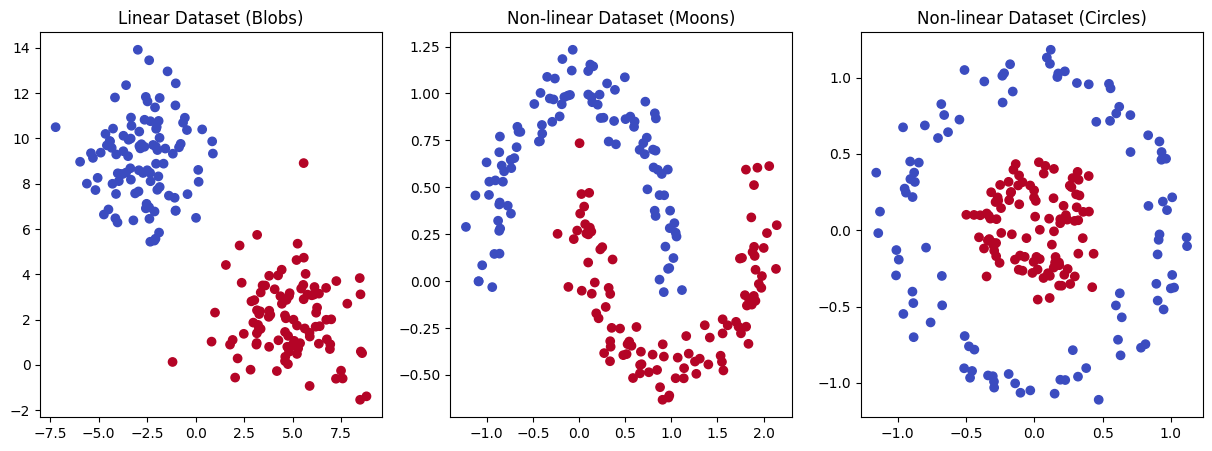

In [397]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles

# Linear dataset (make_blobs)
X_linear, y_linear = make_blobs(
    n_samples=200, centers=2, random_state=42, cluster_std=1.8)
y_linear = np.where(y_linear == 0, -1, 1)  # Convert labels to -1, 1

# Non-linear dataset (make_moons)
X_moons, y_moons = make_moons(n_samples=200, noise=0.1, random_state=42)
y_moons = np.where(y_moons == 0, -1, 1)

# Non-linear dataset (make_circles)
X_circles, y_circles = make_circles(
    n_samples=200, factor=0.3, noise=0.1, random_state=42)
y_circles = np.where(y_circles == 0, -1, 1)

# Visualise datasets
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].scatter(X_linear[:, 0], X_linear[:, 1], c=y_linear, cmap='coolwarm')
ax[0].set_title("Linear Dataset (Blobs)")

ax[1].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='coolwarm')
ax[1].set_title("Non-linear Dataset (Moons)")

ax[2].scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap='coolwarm')
ax[2].set_title("Non-linear Dataset (Circles)")
plt.show()

## Hyperplane and Margin
A hyperplane is a subspace of dimension n-1 in an n-dimensional space, which is used as a decision boundary for SVMs. The formula for linear boundary is:

\begin{align*}
w^{T} \cdot x + b = 0
\end{align*}

where:
- $w$: Weight vector.
- $x$: Points in space.
- $b$: Bias (intercept).

For 2D data, the equation expands to:

\begin{align*}
w_{0} \cdot x_{1} + w_{1} \cdot x_{2} + b = 0
\end{align*}

The margin is the width of the *street* between the two classes:
\begin{align*}
M = \dfrac{2}{||w||}
\end{align*}

and
- $w^{T} \cdot x + b = +1$: Positive Margin.
- $w^{T} \cdot x + b = -1$: Negative Margin.

The critical data points that define the decision boundary (the points within the range of margins) are called **support vectors**.

## Hinge Loss Function
Hinge loss function measures the margin violations for a classifier. For a correct classification, the margin should be at least 1. The hinge loss is given by:

\begin{align*}
L = \dfrac{1}{n} \sum^{n}_{i=1}\text{max}(0, 1 - y_{i}(w \cdot x_{i} + b)) + \dfrac{\lambda}{2}||w||^{2}
\end{align*}

where:
- $\lambda = \dfrac{1}{C}$
- $C$: Regularisation parameter
- $w$: Bias
- $b$: Weights

This function penalises samples that fall inside the margin or on the wrong side of the decision boundary while encouraging a larger margin.

### Hinge Loss Condition
For each sample, the loss function verifies a condition (hinge loss condition) to ensure that the SVM maximises the margin street with minimising misclassification errors.

1. If $y_{i}(w \cdot x_{i} + b) \geq 1$: 
- The sample is correctly classified with a margin greater than or equal to 1 (no loss).
- Update only the regularisation term of $w$.

2. If $y_{i}(w \cdot x_{i} + b) < 1$:
- The sample is either misclassified or within the margin (loss occurs).
- Update both $w$ and $b$ to correct for this violation.

In [398]:
def hinge_loss(w, b, X, y, C):
    """
    Compute the hinge loss for a linear SVM.

    Args:
        w (np.array): Weight vector.
        b (float): Bias term.
        X (np.array): Feature matrix.
        y (np.array): Labels (-1, 1).
        C (float): Regularisation parameter.

    Returns:
        float: Hinge loss value.
    """
    distances = 1 - y * (np.dot(X, w) + b)  # Calculate distances
    hinge_loss = np.mean(np.maximum(0, distances))  # Mean hinge loss
    regularisation_term = (1 / (2 * C)) * np.sum(w**2)  # Regularisation term
    return hinge_loss + regularisation_term

## Gradient Descent
Gradient descent is an optimisation algorithm used to minimise a loss function by iteratively moving towards the local minima and while adjusting hyperparameters. In case of SVM, we update the weights $w$ and bias $b$ by calculating gradients of the hinge loss with a learning rate $\alpha$.

1. For $y_{i}(w \cdot x_{i} + b) \geq 1$:

\begin{align*}
\dfrac{\partial L}{\partial w} = w
\end{align*}

\begin{align*}
\dfrac{\partial L}{\partial b} = 0
\end{align*}

2. For $y_{i}(w \cdot x_{i} + b) < 1$:
\begin{align*}
\dfrac{\partial L}{\partial w} = w - Cy_{i}x_{i}
\end{align*}

\begin{align*}
\dfrac{\partial L}{\partial b} = - Cy_{i}
\end{align*}

Then we use these gradients to update $w$ and $b$.

\begin{align*}
w_{\text{new}} = w_{\text{old}} - \alpha (w - Cy_{i}x_{i})
\end{align*}

\begin{align*}
b_{\text{new}} = b_{\text{old}} + \alpha (Cy_{i})
\end{align*}

In [399]:
# Linear SVM Function
def linear_SVM(X, y, learning_rate=0.01, epochs=1000, C=1.0):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)  # Initialise weights
    b = 0  # Initialise bias

    # Gradient Descent
    for epoch in range(epochs):
        for i in range(n_samples):
            # Hinge loss condition
            condition = y[i] * (np.dot(w, X[i]) + b) < 1
            if condition:
                w -= learning_rate * (w - C * y[i] * X[i])
                b += learning_rate * C * y[i]
            else:
                w -= learning_rate * w

        # Calculate loss
        loss = hinge_loss(w, b, X, y, C)
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs} - Loss: {loss:.4f}")
    return w, b


# Accuracy Function
def accuracy(y_true, y_pred):
    accuracy = np.mean(y_true == y_pred)
    return accuracy


def predict(X, w, b):
    return np.sign(np.dot(X, w) + b)

## Basic Linear SVM
Now, let's create a function to visualise the decision boundary and margins on our dataset, then merge all the functions into a single class. It requires a rearragement of the hyperplane equations:

\begin{align*}
w_{0} \cdot x_{1} + w_{1} \cdot x_{2} + b = 0 \\
\end{align*}

\begin{align*}
w_{1} \cdot x_{2} = - w_{0} \cdot x_{1} - b \\
\end{align*}

\begin{align*}
x_2 &= -\dfrac{w_0}{w_1} \cdot x_i - \dfrac{b}{w_1} \\
    &= \text{y\_values} = -\dfrac{w_0 \cdot \text{x\_values} + b}{w_1}
\end{align*}



In [400]:
class LinearSVM:
    def __init__(self, learning_rate=0.01, epochs=1000, C=1.0):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.C = C
        self.w = None
        self.b = 0

    def hinge_loss(self, X, y):
        distances = 1 - y * (np.dot(X, self.w) + self.b)
        hinge_loss = np.mean(np.maximum(0, distances))
        regularisation_term = (1 / (2 * self.C)) * np.sum(self.w**2)
        return hinge_loss + regularisation_term

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)

        # Gradient Descent
        for epoch in range(self.epochs):
            for i in range(n_samples):
                # Hinge Loss Condition
                condition = y[i] * (np.dot(self.w, X[i]) + self.b) < 1
                if condition:
                    self.w -= self.learning_rate * \
                        (self.w - self.C * y[i] * X[i])
                    self.b += self.learning_rate * self.C * y[i]
                else:
                    self.w -= self.learning_rate * self.w

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    def plot_decision_boundary(self, X, y, ax, title="Linear SVM Decision Boundary"):
        # Plot all data points
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm',
                   edgecolors='k', label="Data Points")

        # Plot support vectors (inside margins)
        decision_values = y * (np.dot(X, self.w) + self.b)
        within_margin_indices = np.where(
            (decision_values > -1) & (decision_values < 1))
        ax.scatter(X[within_margin_indices, 0], X[within_margin_indices, 1],
                   s=100, facecolors='none', edgecolors='orange', label="Support Vectors")

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        x_values = np.linspace(x_min, x_max, 200)

        # Decision boundary
        y_values = -(self.w[0] * x_values + self.b) / self.w[1]

        # Margins
        margin_positive = -(self.w[0] * x_values + self.b - 1) / self.w[1]
        margin_negative = -(self.w[0] * x_values + self.b + 1) / self.w[1]

        ax.plot(x_values, y_values, '-', c='red', label="Decision Boundary")
        ax.plot(x_values, margin_positive, '--', c='grey', label="Margin ±1")
        ax.plot(x_values, margin_negative, '--', c='grey')

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.legend()
        ax.set_title(title)

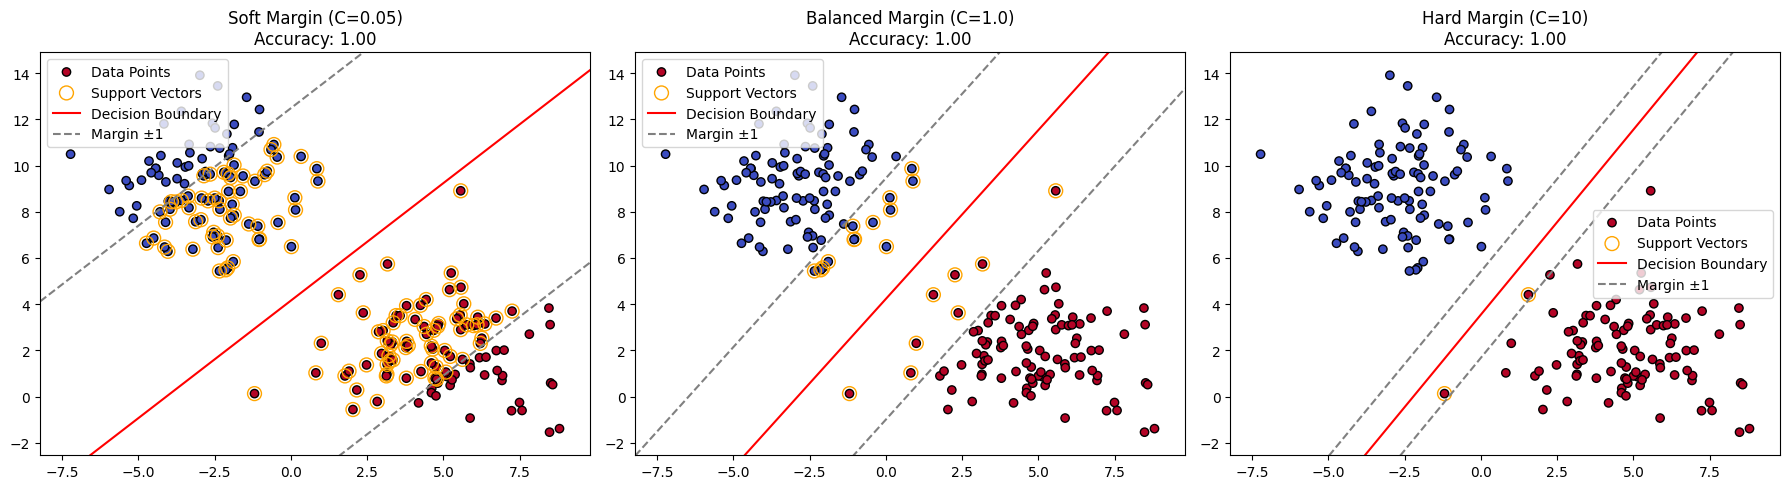

In [401]:
titles = ["Soft Margin (C=0.05)", "Balanced Margin (C=1.0)",
          "Hard Margin (C=10)"]
C_values = [0.05, 1.0, 10]  # Soft, Balanced, Hard margins
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, C in enumerate(C_values):
    svm = LinearSVM(learning_rate=0.01, epochs=1000, C=C)
    svm.fit(X_linear, y_linear)
    y_pred = svm.predict(X_linear)
    acc = svm.accuracy(y_linear, y_pred)
    svm.plot_decision_boundary(X_linear, y_linear, ax=axes[i],
                               title=f"{titles[i]}\nAccuracy: {acc:.2f}")

plt.tight_layout()
plt.show()

Here are three SVM models with different values for the regularisation parameters $C$:
- `C = 0.05`: **Soft margin**, more tolerance for misclassification allowed.
- `C = 1.0`: Balanced case.
- `C = 10.0`: **Hard margin**, almost no misclassification allowed.

## For Non-Linear Problems
Previously, we explicitly found a weight vector $w$ and bias $b$, but this approach only works for linear decision boundaries. The dual formulation provides a solution for non-linear problems. Instead of solving for $w$, we solve for Lagrange multipliers $\alpha_{i}$ associated with each training example:

\begin{align*}
\max_{\alpha} \sum_{i=1}^{n} \alpha_{i} - \dfrac{1}{2} \sum_{i=1}^{n} \sum_{j=1}^{n} \alpha_{i} \alpha_{j} y_{i} y_{j} K(x_{i}, x_{j})
\end{align*}

Subject to:
\begin{align*}
\sum_{i=1}^{n} \alpha_{i} y_{i} = 0, \space \space 0 \leq \alpha_{i} \leq C\
\end{align*}

The final decision function becomes:
\begin{align*}
f(x) = \sum_{i=1}^{n} \alpha_{i} y_{i} K(x_{i}, x) + b
\end{align*}

## Kernel Trick
A kernel ($K$) is a function that computes the similarity (or dot product) between two data points in a higher-dimensional feature space, without explicitly performing the mapping to that space. This technique is known as the **kernel trick**. It allows SVMs to perform non-linear classification without paying the computational cost of working in high-dimensional spaces. Common kernel functions are:

| Kernel         | Formula                                  | Captures                                     |
| -------------- | ---------------------------------------- | -------------------------------------------- |
| Linear         | $K(x, x') = x^\top x'$                   | No transformation — basic dot product        |
| Polynomial     | $K(x, x') = (x^\top x' + c)^d$           | Degree-d polynomial relationships            |
| RBF / Gaussian | $K(x, x') = \exp(-\gamma \|x - x'\|^2)$  | Infinite-dimensional features; very flexible |


In [402]:
# Define Kernel Functions
def linear_kernel(x1, x2):
    return np.dot(x1, x2)


def polynomial_kernel(x1, x2, degree=3, coef0=1):
    return (np.dot(x1, x2) + coef0) ** degree


def rbf_kernel(x1, x2, gamma=0.5):
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

## Kernel Matrix
For dual optimisation, the full Gram matrix $K_{ij} = K(x_i, x_j)$ is required.

In [403]:
# Compute Kernel Matrix
def compute_kernel_matrix(X, kernel_func):
    n_samples = X.shape[0]
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = kernel_func(X[i], X[j])
    return K

## Dual Formulation 1 - cvxopt

To implement dual formulation, we can either:
- Use `cvxopt` library to solve the quadratic programming problem, or
- Implement **Sequential Minimal Optimisation (SMO)**, which is more efficient and scalable.

Let's start with the `cvxopt` version.

In [404]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

### Quadratic Programming (QP)
This is a Quadratic Programming problem of the form:
\begin{align*}
\min_{\alpha} \dfrac{1}{2} \alpha^{T}P \alpha + q^{T} \alpha
\end{align*}
Subject to: $G \alpha \leq h$, $A\alpha = b$

- Compute $K_{ij} = K(x_i, x_j)$, the kernel matrix
- $P = yy^T \odot K$, element-wise multiplication: $P_{ij} = y_i y_j K(x_i, x_j)$
- $q = -1$
- `G_slack`, `h_slack` -> Encodes $\alpha_i \leq C$
- `G`, `h` -> Stack both constraints into:
\begin{align*}
\begin{bmatrix}
-I\\
I 
\end{bmatrix}
\alpha \leq 
\begin{bmatrix}
0\\
C 
\end{bmatrix}
\end{align*}

- `A`, `b` -> Equality constraints: $\sum_{i=1}^{n} \alpha_i y_i$

In [405]:
def train_svm_dual(X, y, C=1.0, kernel=linear_kernel):
    n_samples = X.shape[0]
    K = compute_kernel_matrix(X, kernel)

    # Construct QP matrices
    P = matrix(np.outer(y, y) * K)
    q = matrix(-np.ones(n_samples))
    G_std = matrix(np.diag(-np.ones(n_samples)))  # -alpha ≤ 0
    h_std = matrix(np.zeros(n_samples))
    G_slack = matrix(np.diag(np.ones(n_samples)))  # alpha ≤ C
    h_slack = matrix(np.ones(n_samples) * C)
    G = matrix(np.vstack((G_std, G_slack)))
    h = matrix(np.vstack((h_std, h_slack)))
    A = matrix(y.reshape(1, -1).astype(np.double))
    b = matrix(np.zeros(1))

    # Solve QP problem
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.ravel(solution['x'])

    # Support vectors have non-zero alpha
    sv = alphas > 1e-5
    alpha_sv = alphas[sv]
    X_sv = X[sv]
    y_sv = y[sv]

    # Compute bias term (use K with support vectors)
    b = 0
    for i in range(len(alpha_sv)):
        b += y_sv[i]
        b -= np.sum(alpha_sv * y_sv * K[sv][:, sv][i])
    b /= len(alpha_sv)

    return alpha_sv, X_sv, y_sv, b, kernel

### Decision Function
The decision functions for different kernels:

\begin{align*}
f(x) = \sum_{i=1}^{n} \alpha_{i} y_{i} K(x_{i}, x) + b
\end{align*}


In [406]:
def decision_function(X_test, alpha_sv, X_sv, y_sv, b, kernel):
    f_x = []
    for x in X_test:
        result = 0
        for alpha, sv_y, sv_x in zip(alpha_sv, y_sv, X_sv):
            result += alpha * sv_y * kernel(x, sv_x)
        f_x.append(result + b)
    return np.array(f_x)


def predict_svm(X_test, alpha_sv, X_sv, y_sv, b, kernel):
    return np.sign(decision_function(X_test, alpha_sv, X_sv, y_sv, b, kernel))

In [407]:
def plot_all_kernels(X, y, kernel_dict, title_prefix="Dataset"):
    plt.figure(figsize=(16, 6))
    for i, (kernel_name, kernel_func) in enumerate(kernel_dict.items()):
        alpha_sv, X_sv, y_sv, b, kernel_used = train_svm_dual(
            X, y, C=1.0, kernel=kernel_func)

        # Predict and compute accuracy
        y_pred = predict_svm(X, alpha_sv, X_sv, y_sv, b, kernel_used)
        accuracy = np.mean(y_pred == y)

        # Create grid
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                             np.linspace(y_min, y_max, 300))
        grid = np.c_[xx.ravel(), yy.ravel()]
        Z = decision_function(grid, alpha_sv, X_sv, y_sv,
                              b, kernel_used).reshape(xx.shape)

        ax = plt.subplot(1, 3, i + 1)
        contour = ax.contour(xx, yy, Z, levels=[-1, 0, 1],
                             colors=['grey', 'red', 'grey'],
                             linestyles=['--', '-', '--'])

        # Add labels to contours
        fmt = {level: label for level, label in zip(
            [-1, 0, 1], ['Margin -1', 'Decision Boundary', 'Margin +1'])}
        ax.clabel(contour, inline=True, fontsize=9, fmt=fmt)

        # Plot data
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k', s=40)

        # Plot support vectors and annotate
        ax.scatter(X_sv[:, 0], X_sv[:, 1], s=100, facecolors='none',
                   edgecolors='orange', label='Support Vectors')

        ax.set_title(
            f"{title_prefix} - {kernel_name} Kernel\nAccuracy: {accuracy:.2%}")
        ax.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

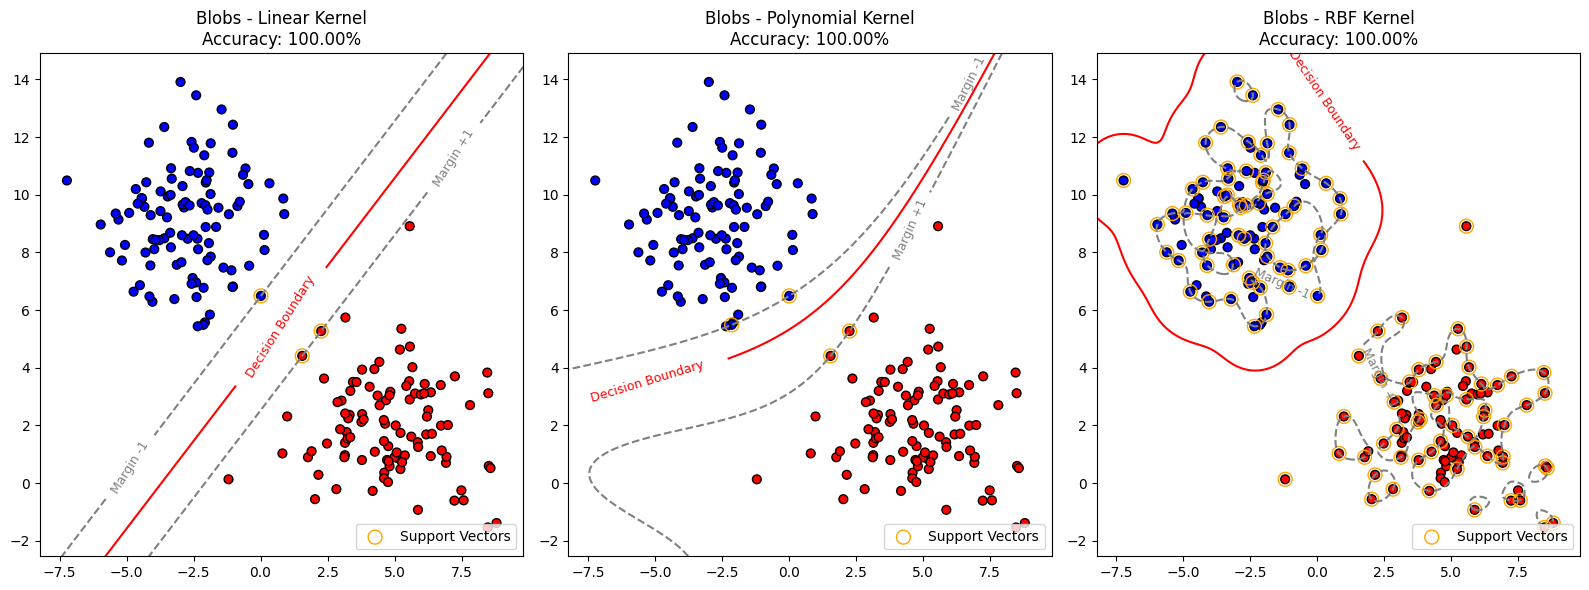

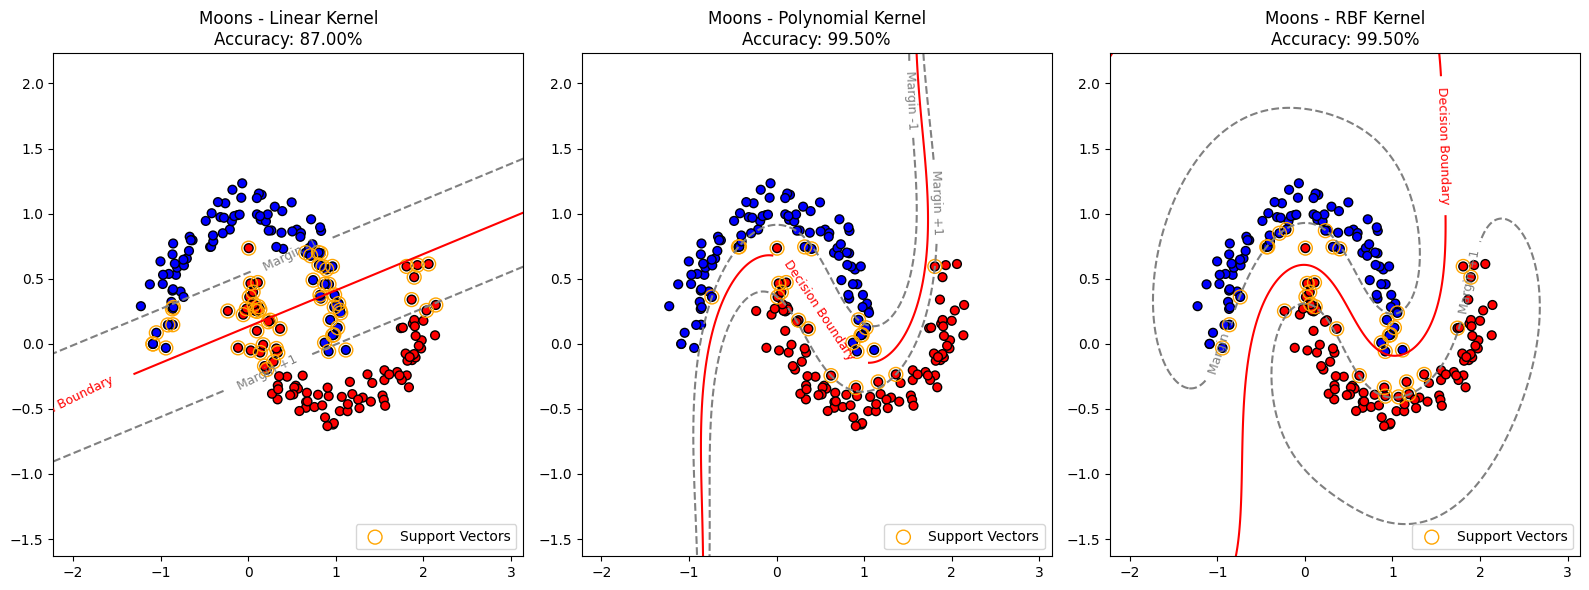

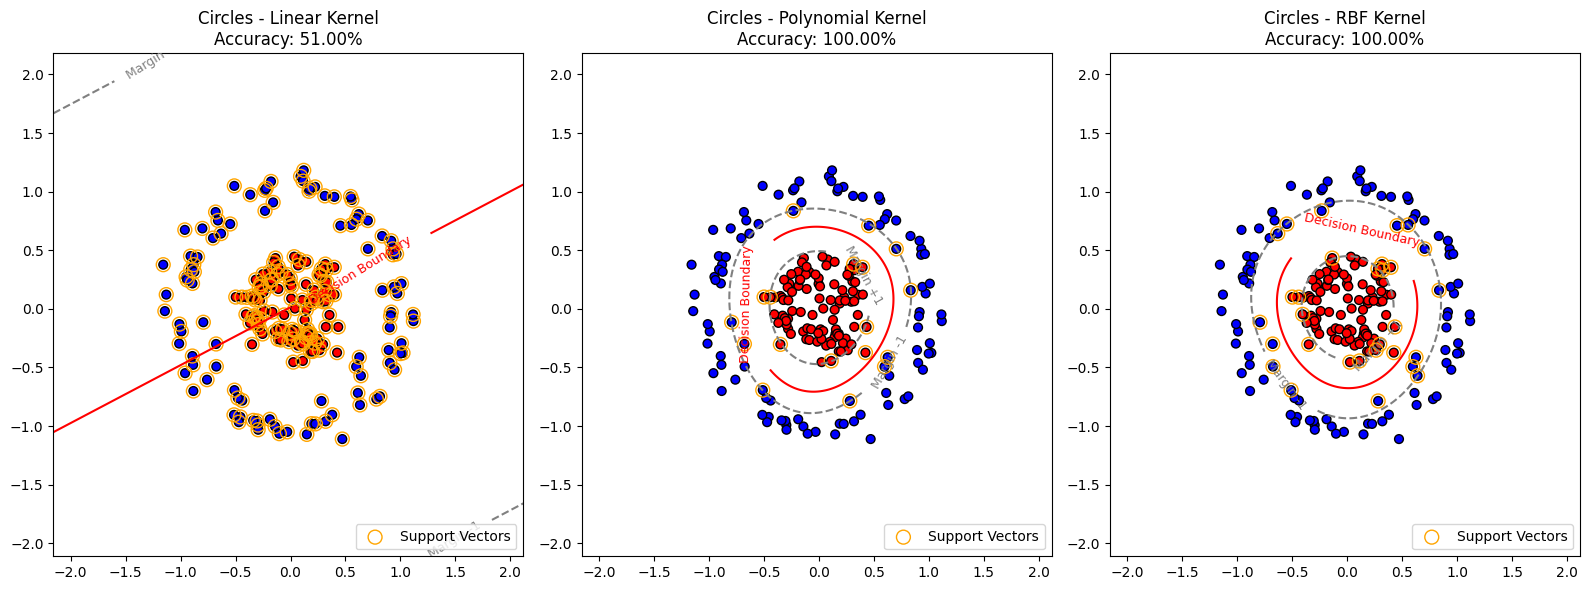

In [408]:
kernel_dict = {
    'Linear': lambda x, y: linear_kernel(x, y),
    'Polynomial': lambda x, y: polynomial_kernel(x, y, degree=3, coef0=1),
    'RBF': lambda x, y: rbf_kernel(x, y, gamma=1.0),
}

# Plot for each dataset
plot_all_kernels(X_linear, y_linear, kernel_dict, title_prefix="Blobs")
plot_all_kernels(X_moons, y_moons, kernel_dict, title_prefix="Moons")
plot_all_kernels(X_circles, y_circles, kernel_dict, title_prefix="Circles")